# Final Project: Segmentation of satellite images

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## U-Net

In [2]:
# necessary imports for U-Net:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPool2D, Cropping2D
from tensorflow.keras import Model

In [3]:
# define convolution block:
class ConvBlock(Model):

    def __init__(self, filters, kernel_size):
        super(ConvBlock, self).__init__()
        self.conv1 = Conv2D(filters, kernel_size, activation="relu", padding="same", kernel_initializer="random_normal", bias_initializer="zeros")
        self.conv2 = Conv2D(filters, kernel_size, activation="relu", padding="same", kernel_initializer="random_normal", bias_initializer="zeros")

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# define encoder (left side of U-Net):
class Encoder(Model):

    def __init__(self, 
            filters = (64, 128, 254, 512, 1024), 
            kernel_size = 3, 
            pool_size = 2):
        super(Encoder, self).__init__()
        self.conv_blocks = []
        for filter in filters:
            self.conv_blocks.append(ConvBlock(filter, kernel_size))
        self.max_pool = MaxPool2D(pool_size)

    def call(self, x):
        x_enc = []
        for i, conv in enumerate(self.conv_blocks):
            x = conv(x)
            x_enc.append(x)
            if i != len(self.conv_blocks):
                x = self.max_pool(x)
        return x_enc

# define decoder (right side of U-Net):
class Decoder(Model):

    def __init__(self, 
            filters = (512, 254, 128, 64), 
            conv_kernel_size = 3, 
            up_conv_kernel_size = 2, 
            stride = 2):
        super(Decoder, self).__init__()
        self.conv_blocks = []
        self.up_conv = []
        for f, filter in enumerate(filters):
            self.up_conv.append(Conv2DTranspose(filter, up_conv_kernel_size, strides=stride, activation="relu", padding="same", kernel_initializer="random_normal", bias_initializer="zeros"))
            self.conv_blocks.append(ConvBlock(filters[f], conv_kernel_size))

    def call(self, x, x_enc):
        for i, conv in enumerate(self.conv_blocks):
            x = self.up_conv[i](x)
            x = tf.concat([x_enc[len(x_enc)-i-2], x], axis=-1)
            x = conv(x)
        return x

In [4]:
# define U-Net as in Ronneberger et al. (2015)
class UNet(Model):

    def __init__(self, 
            input_dim = (512, 512), 
            enc_filters = (64, 128, 254, 512, 1024), 
            dec_filters = (512, 254, 128, 64),
            conv_kernel_size = 3, 
            pool_size = 2, 
            up_conv_kernel_size = 2, 
            n_classes = 4):
        super(UNet, self).__init__()
        self.encoder = Encoder(enc_filters, conv_kernel_size, pool_size)
        self.decoder = Decoder(dec_filters, conv_kernel_size, up_conv_kernel_size, pool_size)
        self.conv = Conv2D(n_classes, 1, activation="softmax", padding="same", kernel_initializer="random_normal", bias_initializer="zeros")

    def call(self, x):
        x_enc = self.encoder(x)
        x = self.decoder(x_enc[len(x_enc)-1], x_enc)
        x = self.conv(x)
        return x

## Dataloader

In [5]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img

# define a dataloader for the training pipe:
class SatelliteData(keras.utils.Sequence):

    FOREST = (4, 135, 29)
    FIELDS = (231, 231, 25)
    URBAN = (229, 109, 109)
    WATER = (14, 10, 214)

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size)
            img_arr = np.array(img)
            forest = np.all(img_arr == self.FOREST, axis=-1)
            y[j][forest] = 0
            fields = np.all(img_arr == self.FIELDS, axis=-1)
            y[j][fields] = 1
            urban = np.all(img_arr == self.URBAN, axis=-1)
            y[j][urban] = 2
            water = np.all(img_arr == self.WATER, axis=-1)
            y[j][water] = 3
        return x, y

In [9]:
import os

data_path = "drive/MyDrive/final_project"
train_input_dir = os.path.join(data_path, "training", "images")
train_target_dir = os.path.join(data_path, "training", "annotations")
val_input_dir = os.path.join(data_path, "validation", "images")
val_target_dir = os.path.join(data_path, "validation", "annotations")
img_size = (512, 512)
num_classes = 4
batch_size = 8

train_input_img_paths = sorted([os.path.join(train_input_dir, fname) for fname in os.listdir(train_input_dir)])
train_target_img_paths = sorted([os.path.join(train_target_dir, fname) for fname in os.listdir(train_target_dir)])

val_input_img_paths = sorted([os.path.join(val_input_dir, fname) for fname in os.listdir(val_input_dir)])
val_target_img_paths = sorted([os.path.join(val_target_dir, fname) for fname in os.listdir(val_target_dir)])

print("Number of samples:", len(train_input_img_paths))

Number of samples: 6304


In [10]:
train_data = SatelliteData(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_data = SatelliteData(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Training

In [19]:
# first training
os.mkdir(os.path.join(data_path, "model01"))
os.mkdir(os.path.join(data_path, "model01", "logs"))

callbacks = [
    tf.keras.callbacks.EarlyStopping(min_delta = 0.01, patience = 3),
    tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(data_path, "model01", "model.{epoch:02d}-{val_loss:.2f}"), save_weights_only = True),
    tf.keras.callbacks.TensorBoard(log_dir = os.path.join(data_path, "model01", "logs")),
]
model = UNet()

model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
epochs = 30
model.fit(train_data, validation_data = val_data, epochs = epochs, callbacks = callbacks)


Epoch 1/30
788/788 [==============================] - 590s 745ms/step - loss: 1849.5184 - val_loss: 0.8371
Epoch 2/30
788/788 [==============================] - 581s 736ms/step - loss: 0.7641 - val_loss: 0.5646
Epoch 3/30
788/788 [==============================] - 582s 738ms/step - loss: 0.6047 - val_loss: 0.5364
Epoch 4/30
788/788 [==============================] - 581s 737ms/step - loss: 0.5687 - val_loss: 0.5123
Epoch 5/30
788/788 [==============================] - 582s 738ms/step - loss: 0.5233 - val_loss: 0.4423
Epoch 6/30
788/788 [==============================] - 572s 726ms/step - loss: 0.5009 - val_loss: 0.4771
Epoch 7/30
788/788 [==============================] - 578s 734ms/step - loss: 0.4930 - val_loss: 0.4700
Epoch 8/30
788/788 [==============================] - 578s 734ms/step - loss: 0.4809 - val_loss: 0.4171
Epoch 9/30
788/788 [==============================] - 577s 732ms/step - loss: 0.4698 - val_loss: 0.4556
Epoch 10/30
788/788 [==============================] - 580s 7

In [42]:
def predict(model, imgs):
  preds = model.predict(imgs)
  preds = np.argmax(preds, axis=-1)
  return preds

def transform_to_rgb(ann):
  FOREST = (4, 135, 29)
  FIELDS = (231, 231, 25)
  URBAN = (229, 109, 109)
  WATER = (14, 10, 214)
  rgb_ann = np.zeros(ann.shape + (3,), dtype="uint8")
  rgb_ann[ann == 0] = FOREST
  rgb_ann[ann == 1] = FIELDS
  rgb_ann[ann == 2] = URBAN
  rgb_ann[ann == 3] = WATER
  return rgb_ann

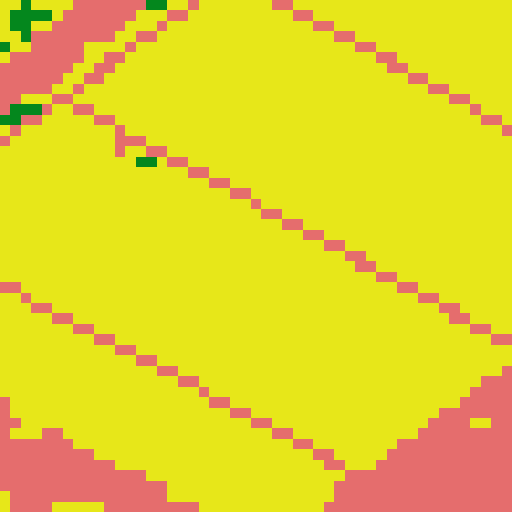

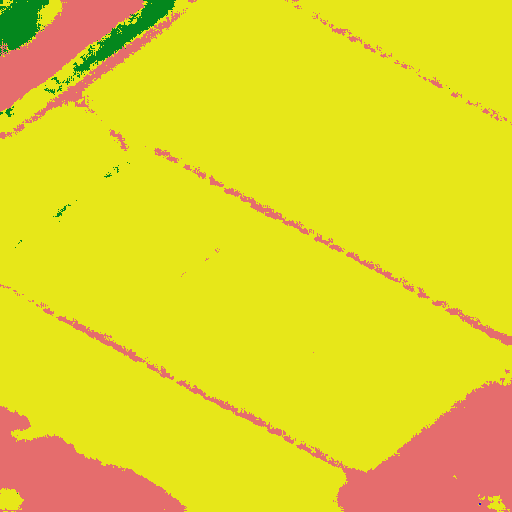

0.07199478149414062


In [46]:
from PIL import Image


imgs, anns = val_data[20]
rgb_ann = transform_to_rgb(anns[1].reshape((512, 512)))
im = Image.fromarray(rgb_ann)
display(im)
pred_anns = predict(model, imgs)
rgb_pred_ann = transform_to_rgb(pred_anns[1].reshape((512, 512)))
im = Image.fromarray(rgb_pred_ann)
display(im)
print(np.mean(anns[1].reshape((512, 512)) != pred_anns[1].reshape((512, 512))))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir "drive/MyDrive/final_project/model01/logs"